In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import math
import tqdm
from PyPDF2 import PdfMerger
import os
from os import listdir
from os.path import isfile, join

2023-05-02 13:04:03.103784: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 13:04:04.027485: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
wireplane = 'Z'

In [3]:
x_test = np.load('processed_data/x_test_' + wireplane + '.npy')
y_test = np.load('processed_data/y_test_AE_' + wireplane + '.npy')


mean = np.load('AutoEncoder-Custom-Loss/results/'+wireplane+'/models/mean_AE_'+wireplane+'.npy')
std = np.load('./AutoEncoder-Custom-Loss/results/'+wireplane+'/models/std_AE_'+wireplane+'.npy')

x_test_scaled = (x_test-mean)/std
y_test_scaled = (y_test-mean)/std

In [5]:
def custom_mse2(y_true, y_pred):

    return -1

In [7]:

ae128 = load_model('./AutoEncoder-Custom-Loss/results/' + wireplane + '/models/batch_size128_' + wireplane + 'plane_nu.h5', custom_objects={'custom_mse2':custom_mse2})
ae128_mse = load_model('./AE_models/model_AE_128_mse' + wireplane + 'plane_nu.h5')

In [8]:
pred_128 = ae128.predict(x_test_scaled, batch_size=4096)
pred_128 = pred_128.reshape(pred_128.shape[0], pred_128.shape[1])

pred_128_mse = ae128_mse.predict(x_test_scaled, batch_size=4096)
pred_128_mse = pred_128_mse.reshape(pred_128_mse.shape[0], pred_128_mse.shape[1])

2023-05-02 13:08:13.381149: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-02 13:08:14.789720: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


25/25 [==============================] - 0s 3ms/step


In [9]:
from scipy import stats
x_test_ = std*x_test_scaled+mean
y_test_ = y_test_scaled*std + mean


pred128 = pred_128*std + mean
pred128_mse = pred_128_mse*std + mean

In [10]:
# takes in prediction of AE and for every wave assigns 0 or 1
# 0 --> predicted as noise
# 1 --> pricicted as containing some kind of signals
# note that this is crude and does not consider how close the predicted signal is from truth
def label_predictions(ae_pred_wave):
    label_ = 0
    if max(abs(ae_pred_wave)) > 3:
        label_ = 1
    return label_


def label_truths(wave):
    label_ = 1
    if max(abs(wave)) <= 3:
        label_ = 0
    return label_

In [11]:
pred_labels128 = [label_predictions(wave) for wave in pred128]
pred_labels128_mse = [label_predictions(wave) for wave in pred128_mse]
truth_labels = [label_truths(t_wave) for t_wave in y_test]

In [12]:
cnn = load_model('ROI_models/model_'+wireplane+'plane_nu_ROI.h5')
cnn_pred = cnn.predict(x_test_scaled, batch_size=4096)
cnn_pred = cnn_pred.squeeze()

25/25 [==============================] - 0s 10ms/step


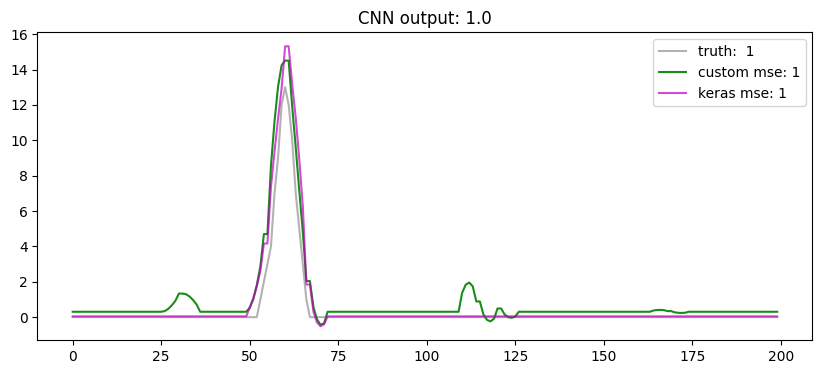

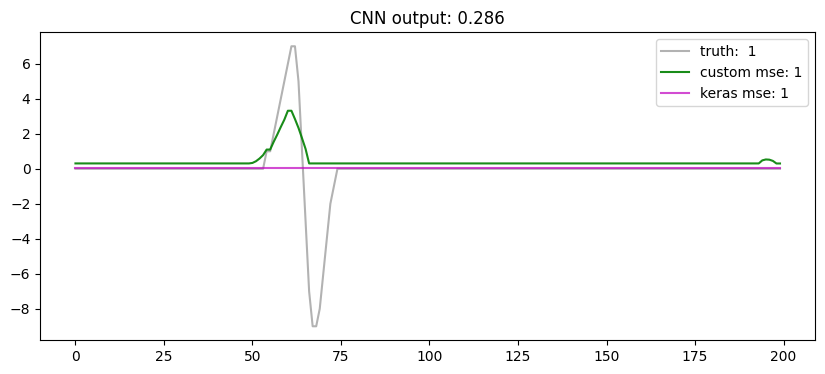

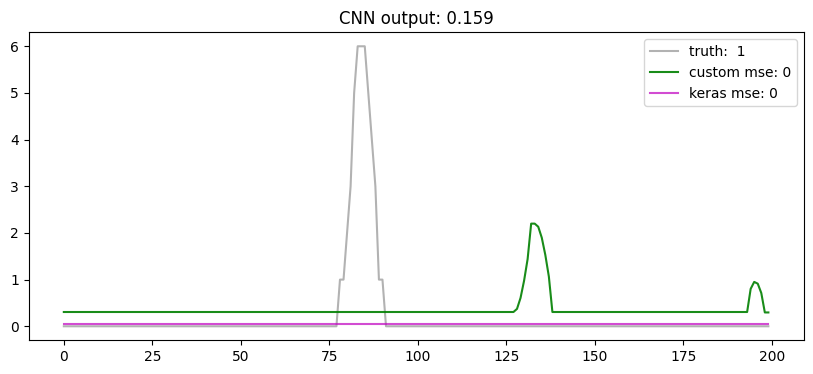

In [16]:
for i in range(10):
    if max(abs(y_test_[i])) < 20 and sum(abs(y_test_[i])) !=0:
        fig = plt.figure(figsize=(10,4))
        plt.plot(y_test_[i], color='black', alpha=0.3, label='truth:  ' + str(truth_labels[i]))
        plt.plot(pred128[i], color='green', alpha=0.9, label='custom mse: ' + str(pred_labels128[i]))
        plt.plot(pred128_mse[i], color='m', alpha=0.7, label='keras mse: ' + str(pred_labels128[i]))
        plt.title('CNN output: ' + str( round(cnn_pred[i], 3)))
        plt.legend()
        plt.show()


In [17]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr128, tpr128, thresholds128 = roc_curve(truth_labels, pred_labels128, drop_intermediate=False)
roc_auc128 = auc(fpr128, tpr128)

fpr128_mse, tpr128_mse, thresholds128_mse = roc_curve(truth_labels, pred_labels128_mse, drop_intermediate=False)
roc_auc128_mse = auc(fpr128_mse, tpr128_mse)

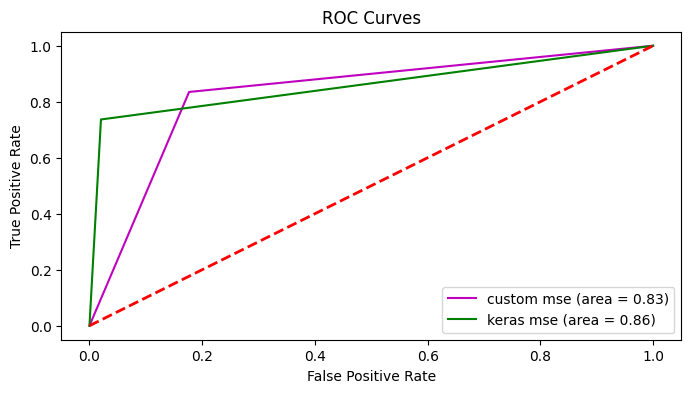

: 

In [18]:
fig = plt.figure(figsize=(8, 4))
plt.plot(fpr128, tpr128, color='m', label='custom mse (area = %0.2f)' % roc_auc128)
plt.plot(fpr128_mse, tpr128_mse, color='g', label='keras mse (area = %0.2f)' % roc_auc128_mse)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2)
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

In [ ]:
def make_single_pdf(wave_idx, pg_num, min_cnn, max_cnn):

    fig, axs = plt.subplots(3,2, figsize=(30, 18), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .375, wspace=.1)

    axes = axs.ravel()

    for i in range(6):
        index_ = i + wave_idx
        max_adc = int((max(x_test_[index_])))
        
        if not (max_adc < 20 and cnn_pred[index_] > min_cnn and cnn_pred[index_] <= max_cnn and sum(abs(y_test_[index_])) != 0):
            while True:
                index_ += 1
                max_adc = int((max(x_test_[index_])))
                
                if (max_adc < 20 and cnn_pred[index_] > min_cnn and cnn_pred[index_] <= max_cnn and sum(abs(y_test_[index_])) != 0):
                    break
        wave_idx = index_


        axes[i].plot(x_test_[index_], color='black',alpha=0.2, label = 'original input (adc_max: ' + str(max_adc) + ')')
        axes[i].plot(y_test_[index_],color='blue', label='target', alpha=1)
        axes[i].plot(pred128[index_], color='m', label='model_128  ---   ' + str(pred_labels128[index_]))
        axes[i].plot(pred128_mse[index_], color='green', label='model_128_cmse  ---   ' + str(pred_labels128_mse[index_]))
        axes[i].legend(fontsize=12)
        axes[i].set_title('CNN output: ' + str(round(cnn_pred[index_], 4)) + ' --- [idx: ' + str(index_) + ']', size=15)
        axes[i].set_ylabel('ADC', size=12)


    plt.savefig('./AE_TEST/plts_cnn_page' + str(pg_num) +  '.pdf',
                dpi=300,
                bbox_inches='tight', pad_inches=0.75)
    plt.close()

    return wave_idx